In [1]:
import torch
device = (
    #Nvidia GPU
    "cuda"
    if torch.cuda.is_available()
    #Apple GPU
    else "mps"
    if torch.backends.mps.is_available()
    #Other
    else "cpu"
)
print(f"Using {device} device")

Using mps device


1. Import the Fashion MNIST dataset including the data labels. This would import two sets (training set and test set). Create a third set (validation set) by splitting the training set into two (training set and validation set) for validation purposes. Decide what a good ratio of training/validation is, and motivate your choice. You should use the validation set to evaluate the different choices you make when building your CNNs. Keep in mind that the test set will only be used at the very final stage and will not be included in the validation step.

In [2]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

#NOTE: data is not normalised yet
train_data = datasets.FashionMNIST('Data', download=True, train=True, transform=ToTensor())
test_data = datasets.FashionMNIST('Data', download=True, train=False, transform=ToTensor())

splitlength = [50000,10000]
#NOTE: This needs to be changed to be calculated using a percentage if we are going to have variable data lenghts (due to e.g. data augmentation)
train_data, val_data = random_split(train_data, splitlength)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

torch.Size([1, 28, 28]) tensor(5)


/var/folders/l5/nls_4lyj0jz80t53mhj1whym0000gn/T/ipykernel_26585/107852122.py:80: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.int64)


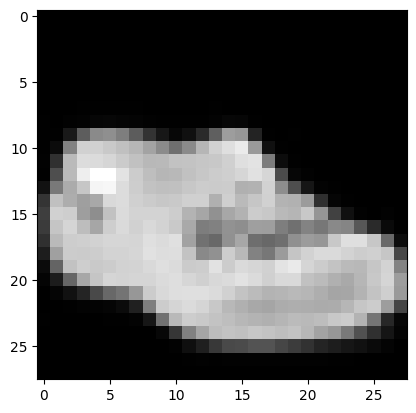

In [35]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

sub_category_to_class = {
    "Topwear": "T-shirt/top",
    "Bottomwear": "Trouser",
    "Dresses": "Dress",
    "Shirts": "Shirt",
    "Jeans": "Trouser",
    "Sweatshirts": "Pullover",
    "Track Pants": "Trouser",
    "Tshirts": "T-shirt/top",
    "Tops": "T-shirt/top",
    "Socks": "Sneaker",
    "Shoes": "Sneaker",
    "Casual Shoes": "Sneaker",
    "Formal Shoes": "Sneaker",
    "Sandal": "Sandal",
    "Flip Flops": "Sandal",
    "Shoe Accessories": "Sandal",
    "Flats": "Sneaker",
    "Sports Shoes": "Sneaker",
    "Sweatshirts": "Pullover",
    "Kurtas": "Dress",
    "Briefs": "Trouser",
    "Shorts": "Trouser",
    "Waistcoat": "Coat",
    "Blazers": "Coat",
    "Jackets": "Coat",
    "Bags": "Bag",
    "Handbags": "Bag",
}

def map_sub_category_to_class(sub_category):
    class_label = sub_category_to_class.get(sub_category)
    if class_label is None:
        return None
    return classes.index(class_label)

class CustomFashionDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_excel(csv_file)
        self.filtered_data = self.data[
            ~self.data['masterCategory'].isin(['Personal Care'])
        ]
        self.filtered_data = self.filtered_data[
            ~self.filtered_data['subCategory'].isin(['Watches', 'Belts', 'Bracelet', 'Jewellery', 'Socks'])
        ]
        self.filtered_data['label'] = self.filtered_data['subCategory'].apply(map_sub_category_to_class)
        self.labels = self.filtered_data['label'].tolist()
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = self.filtered_data.iloc[idx, 0] 
        label = self.labels[idx]

        image_filename = f"{image_id}.jpg"  # Assuming image filenames are based on their IDs
        image_path = os.path.join(self.image_dir, image_filename)

        try:
            image = Image.open(image_path)
            if label is None or pd.isna(label):
                return self[idx + 1]

            if self.transform:
                image = self.transform(image)

            label = torch.tensor(label, dtype=torch.int64)
            return image, label

        except FileNotFoundError:
            print(f"File not found: {image_filename}. Skipping...")
            return self[idx + 1]

# Define transformations
transform = transforms.Compose([
    transforms.CenterCrop(40), 
    transforms.Resize((28, 28)),       
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),               
    transforms.Lambda(lambda x: 1 - x),  # Invert colors
])

# Create custom dataset
custom_dataset = CustomFashionDataset(csv_file="FashionProductImages/styles.xlsx",
                                      image_dir="FashionProductImages/myntradataset/images",
                                      transform=transform)

# Create DataLoader
custom_dataloader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

image, label = custom_dataset[10]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

torch.Size([1, 28, 28]) 1


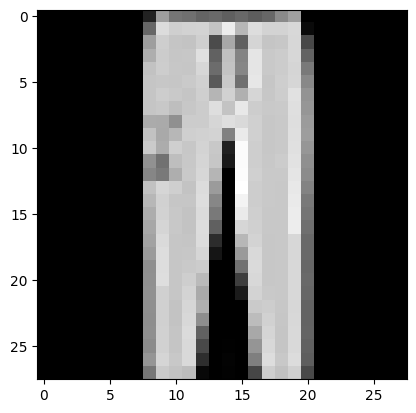

In [27]:
image, label = train_data[1000]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

2. Recreate the LeNet-5 architecture as your baseline. The model takes as input a greyscale image of size 28x28x1 and has 10 outputs, one for each class. Make sure all parameters (number of neurons, number and size of kernels) is the same as in the original architecture. You may assume that no zero-padding was applied. The model is trained using cross-entropy loss, Adam optimizer with a learning rate of 0.001. Use torch.nn.init.kaiming_uniform to initialize your weights. Use a batch size of 32, unless your hardware doesn't allow you to. Then reduce the size accordingly.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # 16 channels, 5x5 feature map size
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [6]:
from torchkeras import summary

model = LeNet5()

def check_weights():
    for param in model.parameters():
        print(param.data)

def summarize(model):
    summary(model=model, input_shape=(1,28,28))

summarize(model)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                             [-1, 6, 28, 28]                  156
ReLU-2                               [-1, 6, 28, 28]                    0
AvgPool2d-3                          [-1, 6, 14, 14]                    0
Conv2d-4                            [-1, 16, 10, 10]                2,416
ReLU-5                              [-1, 16, 10, 10]                    0
AvgPool2d-6                           [-1, 16, 5, 5]                    0
Flatten-7                                  [-1, 400]                    0
Linear-8                                   [-1, 120]               48,120
ReLU-9                                     [-1, 120]                    0
Linear-10                                   [-1, 84]               10,164
ReLU-11                                     [-1, 84]                    0
Linear-12                            

In [7]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(loader, model, criterion, optimizer):
    size = len(loader.dataset)
    batches = len(loader)
    model.train()
    loss_list = []
    total_loss = 0

    for n, batch in enumerate(tqdm(loader)):
        X,y = batch
        optimizer.zero_grad()
        
        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

def test(loader, model, criterion):
    size = len(loader.dataset)
    batches = len(loader)
    total_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in loader:
            X,y = batch
            pred = model(X)
            
            loss = criterion(pred, y)
            total_loss += loss.item()

            y = y.data.numpy()
            y_true.extend(y)
            pred = pred.argmax(1).data.numpy()
            y_pred.extend(pred)

    loss = total_loss / batches
    accuracy = accuracy_score(y_true, y_pred)

    print(f"loss: {loss}\naccuracy: {accuracy}")
    return y_true, y_pred, loss

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []
accuracy_train = []
accuracy_test = []

def train_test_loop(model, criterion, optimizer, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}\n----------------")
        print("Training:")
        train(loader=train_dataloader, model=model, criterion=criterion, optimizer=optimizer)

        print("Testing (train-set):")
        y_true_train, y_pred_train, loss_train = test(loader=train_dataloader, model=model, criterion=criterion)
        print("Testing (test set):")
        y_true_test, y_pred_test, loss_test = test(loader=val_dataloader, model=model, criterion=criterion)
        #print("Custom set (fashion product images set):")
        #y_true_custom, y_pred_custom, loss_custom = test(loader=custom_dataloader, model=model, criterion=criterion)

        accuracy_train.append(accuracy_score(y_true_train, y_pred_train))
        accuracy_test.append(accuracy_score(y_true_test, y_pred_test))

        losses_train.append(loss_train)
        losses_test.append(loss_test)

    plot_loss(losses_train, losses_test, epochs)
    plot_accuracy(accuracy_train, accuracy_test, epochs)
    return y_true_test, y_pred_test

    print("----------------")

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, classes, classes)
    sn.heatmap(conf_matrix, annot=True, fmt= 'g')
    cr = classification_report(y_true, y_pred, target_names=classes)
    print(cr)

def plot_accuracy(train_acc, test_acc, epochs):
    plt.plot(range(1, epochs+1), train_acc, label="train")
    plt.plot(range(1, epochs+1), test_acc, label="validation")
    plt.legend()
    plt.show()

def plot_loss(train_losses, test_losses, epochs):
    plt.plot(range(1, epochs+1), train_losses, label="train")
    plt.plot(range(1, epochs+1), test_losses, label="validation")
    plt.legend()
    plt.show()

#print(losses_train, losses_test)
#evaluate(y_true_test,y_pred_test)
#plot_loss(losses_train, losses_test, epochs)

3. Now create four model variants. Each model may differ from the previous model by only one aspect, such that we can compare each pair of subsequent models pair-wise. An aspect should be a meaningful property, e.g., change the type of one layer (convolution --> pooling, etc.), add one layer, use dropout, change your activation function, change the number or size of your kernels, change the learning rate, etc. No use of any merging, attention, recurrent or locally-connected layers. Your variants should be aimed at getting a better performance. We keep the batch sizes fixed so choose a number and keep it constant for all models (including the baseline model).

In [9]:
'''
options:

Dropout
Learning rate (+++, 0.01 -> 0.001)
Activation function
More/Less layers
 - extra linear layer (+/-, 400 -> 220)
 - extra conv layer
 - more convolution kernels (++, 6->16, 16-> 26)
Pooling type
Normalisation

loss_fn/optimizer/weight init (I dont think this will do much)

grid-search?
'''

'\noptions:\n\nDropout\nLearning rate (+++, 0.01 -> 0.001)\nActivation function\nMore/Less layers\n - extra linear layer (+/-, 400 -> 220)\n - extra conv layer\n - more convolution kernels (++, 6->16, 16-> 26)\nPooling type\nNormalisation\n\nloss_fn/optimizer/weight init (I dont think this will do much)\n\ngrid-search?\n'

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class Var1(nn.Module):
    def __init__(self):
        super(Var1, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 120),  # 16 channels, 5x5 feature map size
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Epoch 1
----------------
Training:


100%|██████████| 1563/1563 [00:25<00:00, 60.63it/s]


Testing (train-set):
loss: 0.35402505698012604
accuracy: 0.87296
Testing (test set):
loss: 0.35688277791007256
accuracy: 0.8723
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:27<00:00, 57.60it/s]


Testing (train-set):
loss: 0.2932525910437107
accuracy: 0.89276
Testing (test set):
loss: 0.3110432288469598
accuracy: 0.8884
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:26<00:00, 57.95it/s]


Testing (train-set):
loss: 0.26361372049895526
accuracy: 0.90124
Testing (test set):
loss: 0.2897403807447741
accuracy: 0.8914
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:29<00:00, 53.18it/s]


Testing (train-set):
loss: 0.22608136642850596
accuracy: 0.9171
Testing (test set):
loss: 0.25698484105471603
accuracy: 0.9079
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:27<00:00, 57.63it/s]


Testing (train-set):
loss: 0.21202588758371194
accuracy: 0.92294
Testing (test set):
loss: 0.2651646309695876
accuracy: 0.9041
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:27<00:00, 57.54it/s]


Testing (train-set):
loss: 0.18955049994362902
accuracy: 0.92928
Testing (test set):
loss: 0.2558654794475427
accuracy: 0.9082
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:26<00:00, 58.50it/s]


Testing (train-set):
loss: 0.1833344295427861
accuracy: 0.93412
Testing (test set):
loss: 0.2506917707336406
accuracy: 0.9129
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:27<00:00, 57.64it/s]


Testing (train-set):
loss: 0.16592526770961338
accuracy: 0.93852
Testing (test set):
loss: 0.24835496383626907
accuracy: 0.9163
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:27<00:00, 56.63it/s]


Testing (train-set):
loss: 0.16079507724060818
accuracy: 0.93936
Testing (test set):
loss: 0.2682015154951106
accuracy: 0.9102
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:25<00:00, 60.97it/s]


Testing (train-set):
loss: 0.12807362510954398
accuracy: 0.95332
Testing (test set):
loss: 0.24430064870098148
accuracy: 0.9177
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:25<00:00, 61.53it/s]


Testing (train-set):
loss: 0.1232762267009873
accuracy: 0.95374
Testing (test set):
loss: 0.2610318919185537
accuracy: 0.9167
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:24<00:00, 63.29it/s]


Testing (train-set):
loss: 0.12819021789420226
accuracy: 0.9509
Testing (test set):
loss: 0.2648281961643753
accuracy: 0.9138
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:24<00:00, 63.00it/s]


Testing (train-set):
loss: 0.10687925597942975
accuracy: 0.95902
Testing (test set):
loss: 0.2699608681106065
accuracy: 0.9183
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:24<00:00, 63.05it/s]


Testing (train-set):
loss: 0.09872354262717598
accuracy: 0.96368
Testing (test set):
loss: 0.2823275467291617
accuracy: 0.915
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:25<00:00, 62.50it/s]


Testing (train-set):
loss: 0.08346866961447635
accuracy: 0.96908
Testing (test set):
loss: 0.28713079125355606
accuracy: 0.915


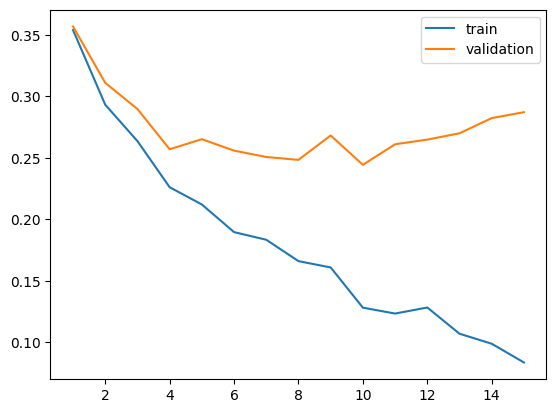

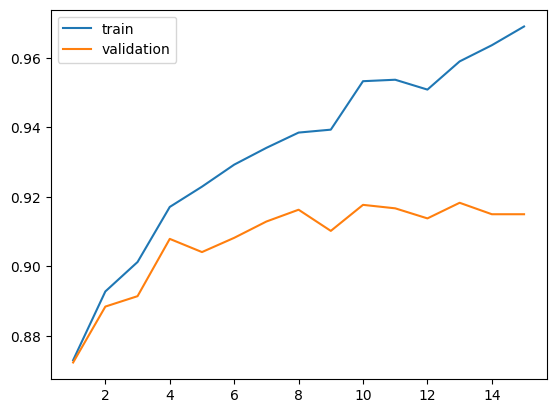

([8,
  5,
  0,
  9,
  8,
  4,
  9,
  3,
  1,
  3,
  1,
  6,
  9,
  7,
  4,
  4,
  7,
  1,
  6,
  4,
  5,
  2,
  3,
  9,
  9,
  8,
  6,
  0,
  4,
  2,
  1,
  9,
  0,
  3,
  3,
  2,
  1,
  3,
  7,
  0,
  1,
  7,
  7,
  7,
  2,
  5,
  5,
  7,
  9,
  5,
  7,
  8,
  9,
  4,
  4,
  9,
  5,
  7,
  0,
  6,
  5,
  1,
  3,
  4,
  6,
  3,
  7,
  4,
  8,
  5,
  2,
  8,
  9,
  1,
  6,
  9,
  2,
  0,
  7,
  0,
  7,
  3,
  9,
  1,
  8,
  5,
  9,
  9,
  0,
  2,
  5,
  6,
  3,
  7,
  2,
  4,
  3,
  4,
  9,
  3,
  2,
  1,
  8,
  1,
  0,
  0,
  2,
  9,
  2,
  7,
  6,
  4,
  9,
  5,
  3,
  4,
  3,
  8,
  1,
  2,
  2,
  7,
  2,
  4,
  7,
  0,
  6,
  9,
  8,
  8,
  0,
  8,
  9,
  6,
  7,
  0,
  0,
  9,
  7,
  4,
  0,
  0,
  3,
  6,
  4,
  2,
  6,
  4,
  7,
  3,
  5,
  7,
  1,
  8,
  9,
  4,
  3,
  4,
  9,
  7,
  7,
  6,
  4,
  3,
  2,
  5,
  2,
  8,
  6,
  9,
  4,
  1,
  5,
  0,
  9,
  4,
  0,
  8,
  1,
  1,
  2,
  1,
  4,
  7,
  9,
  9,
  3,
  2,
  6,
  4,
  7,
  9,
  3,
  5,
  4,
  0,
  0,
  6,
  4,
  1,


In [38]:
model = Var1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []

train_test_loop(model, criterion, optimizer, epochs)